## Partitioning
Problem statement:
 - We need to partition a spectrum many times, in some cases this leads to partitions without peaks, therefore making a Tp and pDir impossible to calculate

In [10]:
import os
import sys
sys.path.append(os.path.abspath("/cws/op/webapps/er_ml_projects/davink/amphitrite"))

In [11]:
import matplotlib
import readSpectrum
import wavespectra

Read spectrum and select just one site

In [16]:
file_name = '/cws/data/wavewatch/IDY35050_G3_2023110712.nc'
spec = readSpectrum.amendVariablesNames(file_name)

In [13]:
spec

<xarray.Dataset>
Dimensions:       (time: 241, site: 236, freq: 28, dir: 30)
Coordinates:
  * time          (time) datetime64[ns] 2023-11-07T12:00:00 ... 2023-11-17T12...
  * site          (site) float64 1.0 2.0 3.0 4.0 5.0 ... 233.0 234.0 235.0 236.0
  * freq          (freq) float32 0.04118 0.0453 0.04983 ... 0.4462 0.4908 0.5399
  * dir           (dir) float32 264.0 252.0 240.0 228.0 ... 300.0 288.0 276.0
Data variables:
    lon           (site) float32 ...
    lat           (site) float32 ...
    dpt           (time, site) float32 ...
    wspd          (time, site) float32 ...
    wdir          (time, site) float32 ...
    efth          (time, site, freq, dir) float32 9.634e-08 ... 7.117e-05
    station_name  (site) <U10 'Weipa' 'Bateman' ... 'Griffin' 'Stybarrow'
Attributes: (12/16)
    product_name:           G0816.2023_src.nc
    area:                   G0816M2Sv3
    data_type:              OCO spectra 2D
    format_version:         1.1
    southernmost_latitude:  n/a
    northernmost_latitude:  n/a
    ...                     ...
    minimum_altitude:       n/a
    maximum_altitude:       n/a
    altitude_resolution:    n/a
    start_date:             2023-11-07 12:00:00
    stop_date:              2023-11-17 12:00:00
    field_type:             hourly

In [17]:
sites = 'Pluto'
df = spec.station_name.to_dataframe()
pluto_spec = spec.sel(site = df.loc[df.station_name.str.contains(sites),:].index.to_list())

In [18]:
spec = readSpectrum.amendVariablesNames(file_name)
sites = 'Pluto'
df = spec.station_name.to_dataframe()
pluto_spec = spec.sel(site = df.loc[df.station_name.str.contains(sites),:].index.to_list())

In [19]:
pluto_spec

<xarray.Dataset>
Dimensions:       (time: 241, site: 1, freq: 28, dir: 30)
Coordinates:
  * time          (time) datetime64[ns] 2023-11-07T12:00:00 ... 2023-11-17T12...
  * site          (site) float64 176.0
  * freq          (freq) float32 0.04118 0.0453 0.04983 ... 0.4462 0.4908 0.5399
  * dir           (dir) float32 264.0 252.0 240.0 228.0 ... 300.0 288.0 276.0
Data variables:
    lon           (site) float32 ...
    lat           (site) float32 ...
    dpt           (time, site) float32 ...
    wspd          (time, site) float32 ...
    wdir          (time, site) float32 ...
    efth          (time, site, freq, dir) float32 4.441e-05 ... 0.0001152
    station_name  (site) <U10 'Pluto'
Attributes: (12/16)
    product_name:           G0816.2023_src.nc
    area:                   G0816M2Sv3
    data_type:              OCO spectra 2D
    format_version:         1.1
    southernmost_latitude:  n/a
    northernmost_latitude:  n/a
    ...                     ...
    minimum_altitude:       n/a
    maximum_altitude:       n/a
    altitude_resolution:    n/a
    start_date:             2023-11-07 12:00:00
    stop_date:              2023-11-17 12:00:00
    field_type:             hourly

Setup our partition function

In [20]:
st = 13
ed = 18

In [21]:
part = pluto_spec.spec.split(fmin=1/ed, fmax =1/st )

In [22]:
part

<xarray.DataArray (time: 241, site: 1, freq: 5, dir: 30)>
dask.array<xarray-<this-array>, shape=(241, 1, 5, 30), dtype=float64, chunksize=(241, 1, 5, 30), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2023-11-07T12:00:00 ... 2023-11-17T12:00:00
  * site     (site) float64 176.0
  * freq     (freq) float64 0.05556 0.06029 0.06632 0.07295 0.07692
  * dir      (dir) float32 264.0 252.0 240.0 228.0 ... 312.0 300.0 288.0 276.0

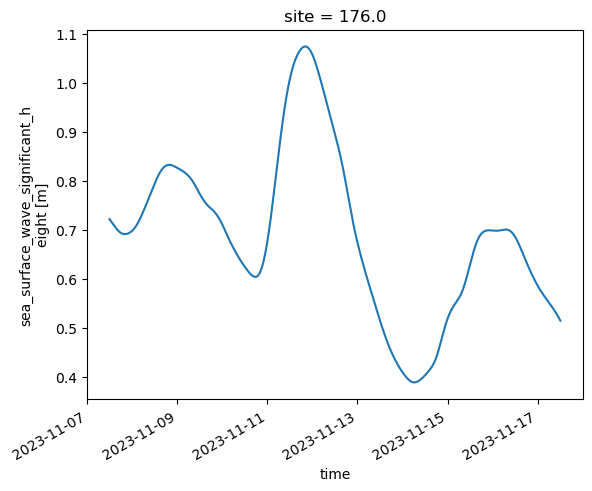

In [23]:
part.isel(site = 0).spec.hs().plot()

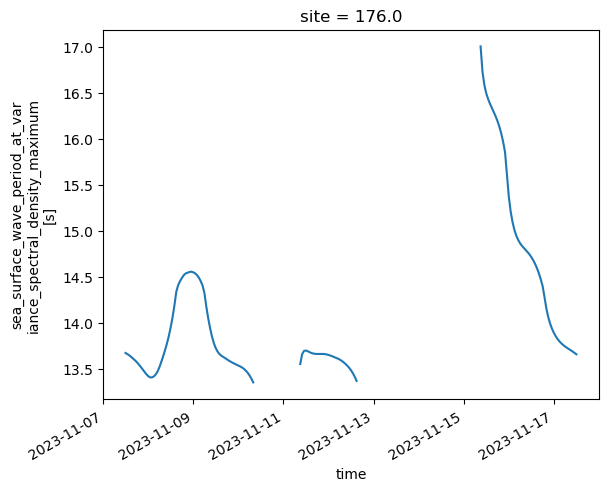

In [24]:
part.isel(site = 0).spec.tp().plot()

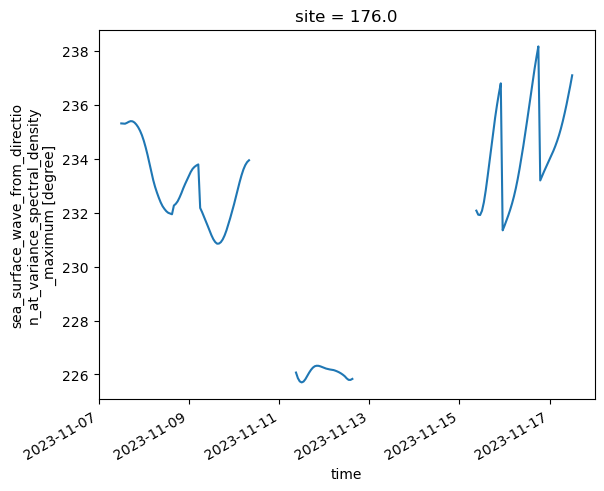

In [25]:
part.isel(site = 0).spec.dpm().plot()

Bits missing, that is becuase there are no peaks in those timesteps of the spectrum.

In [27]:
import seaborn as sns
import numpy as np

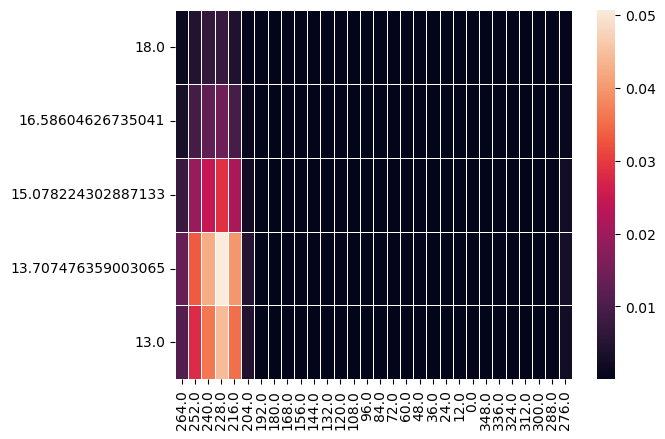

In [28]:
data = part.isel(time = 0, site = 0).load()
ax = sns.heatmap(data, linewidth=0.5, yticklabels = 1/part.freq.values, xticklabels = part.dir.values)

Step 1:
Get the location of the peak energy.

In [29]:
np.where(data == data.max())

(array([3]), array([3]))

Step 2: Calculate the peak frequency and then convert to seconds

In [30]:
tp = 1/part.isel(freq = np.where(data == data.max())[0]).freq.values

Step 3: Calculate the peak direction

In [31]:
part.isel(dir = np.where(data == data.max())[1]).dir.values

array([228.], dtype=float32)

## Code optimisation
We need to perform the above function for all timeseries (without a for loop ideally)

In [32]:
from wavespectra import core

In [33]:
tp = part.spec.tp(smooth=False).fillna(1 / part.freq.max())

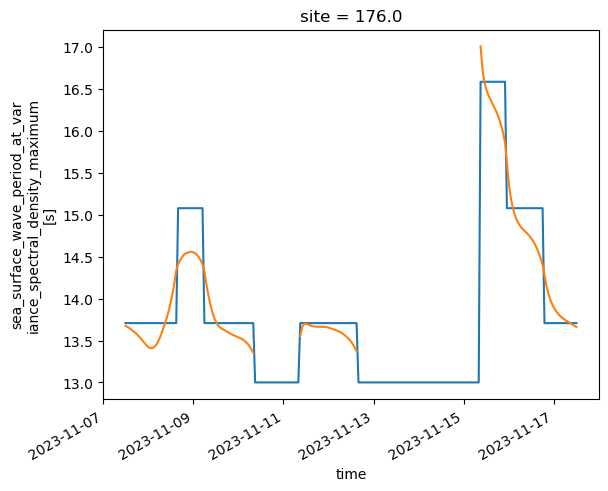

In [34]:
tp.plot()
part.spec.tp().plot()

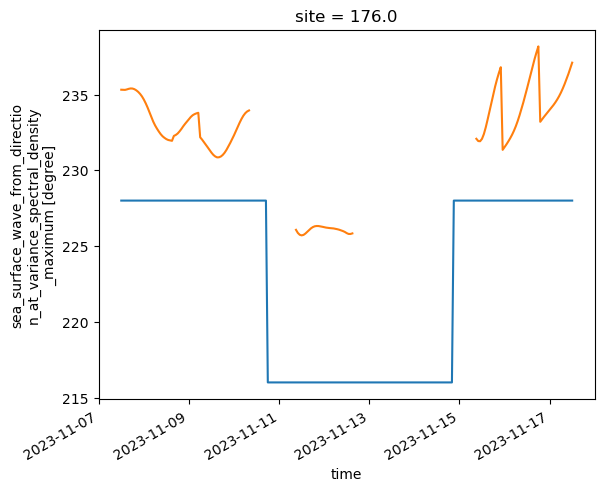

In [35]:
part.spec.dp().plot()
part.spec.dpm().plot()

Tp smoothed and 

In [36]:
import xarray as xr
from numba import guvectorize

In [37]:
ipeak = part.spec._peak(part)

In [38]:
msin, mcos = part.spec.momd(part)